In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Sequential

2024-04-04 19:34:05.834317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 19:34:06.395078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
file_path = "dataset.json"

In [3]:
X = []
Y = []

with open(file_path, "r") as json_file:
    for d in json.load(json_file):
        X.append(d["externalStatus"])
        Y.append(d["internalStatus"])

In [4]:
unique_labels = list(set(Y))
idx_label = dict()
label_idx = dict()

for idx, label in enumerate(unique_labels):
    idx_label[idx] = label
    label_idx[label] = idx

In [5]:
df = pd.DataFrame({
    "External Status": X,
    "Internal Status": Y,
    "Class ID": [label_idx[label] for label in Y]
})
df.head()

,External Status,Internal Status,Class ID
0,PORT OUT,Port Out,5
1,TERMINAL IN,Inbound Terminal,10
2,PORT IN,Port In,9
3,Vessel departure from first POL (Vessel name :...,Departure,4
4,Vessel arrival at final POD (Vessel name : TIA...,Arrival,6


In [6]:
unique_values, counts = np.unique(df["Class ID"], return_counts=True)

In [7]:
print(len(df))
without_duplicates = df.drop_duplicates()
print(len(without_duplicates))
df = without_duplicates

1222
108


In [8]:
from transformers import BartTokenizer, BartModel
import numpy as np

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartModel.from_pretrained('facebook/bart-base')
embeddings = []
mx = 0
for i in df["External Status"]:
    inputs = tokenizer(i, return_tensors="pt")
    outputs = model(**inputs)
    last_hidden_states = np.ravel(outputs.last_hidden_state.detach().numpy())
    embeddings.append(last_hidden_states)
    n = len(last_hidden_states)
    if n > mx:
        mx = n

In [9]:
embeddings = [np.pad(item, (0, mx - len(item)), mode='constant')
              for item in embeddings]

In [10]:
trainX, trainY = np.expand_dims(np.array(embeddings), axis=-1), pd.get_dummies(
    df["Class ID"]).astype(float)

In [11]:
model = Sequential()
model.add(layers.Input(shape=(19968, )))
model.add(layers.Dense(64, activation="selu", ))
model.add(layers.Dense(32, activation="selu"))
model.add(layers.Dense(15, activation="softmax"))


model.compile(optimizer='adam', loss="mean_squared_error")
model.summary()

2024-04-04 19:34:25.188490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 19:34:25.188714: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │     1,278,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,591 (4.89 MB)

 Trainable params: 1,280,591 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
epochs = 2
history = model.fit(
    trainX, trainY,
    epochs=epochs
)

Epoch 1/2


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0632  
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0422 


In [13]:
pred_labels = np.argmax(model.predict(trainX), axis=1)
true_labels = np.argmax(trainY, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
conf_matrix = confusion_matrix(true_labels, pred_labels)
conf_matrix

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  3],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  1,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  5,  0,  0,  1,  0,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  1,  0

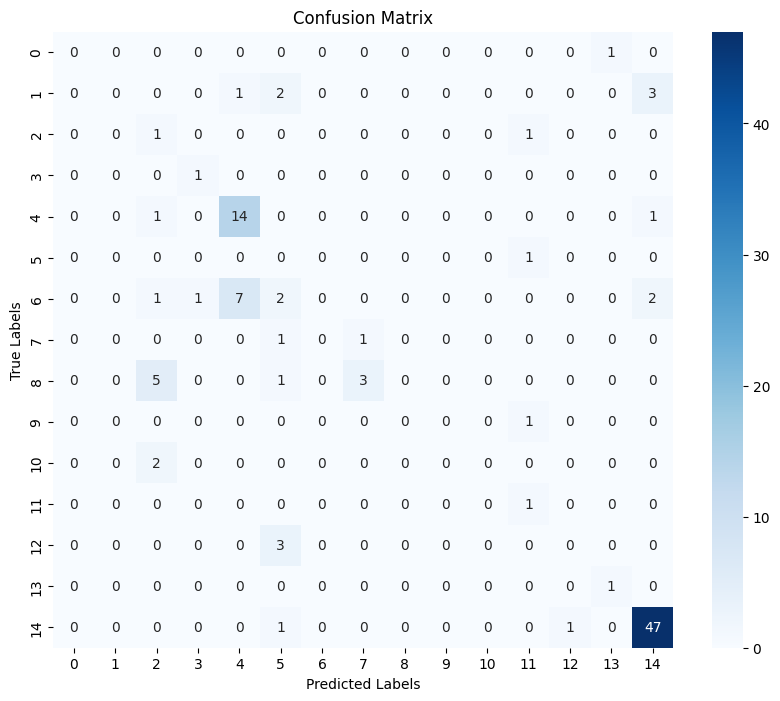

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The below confusion matrix is drawn by including duplicate data

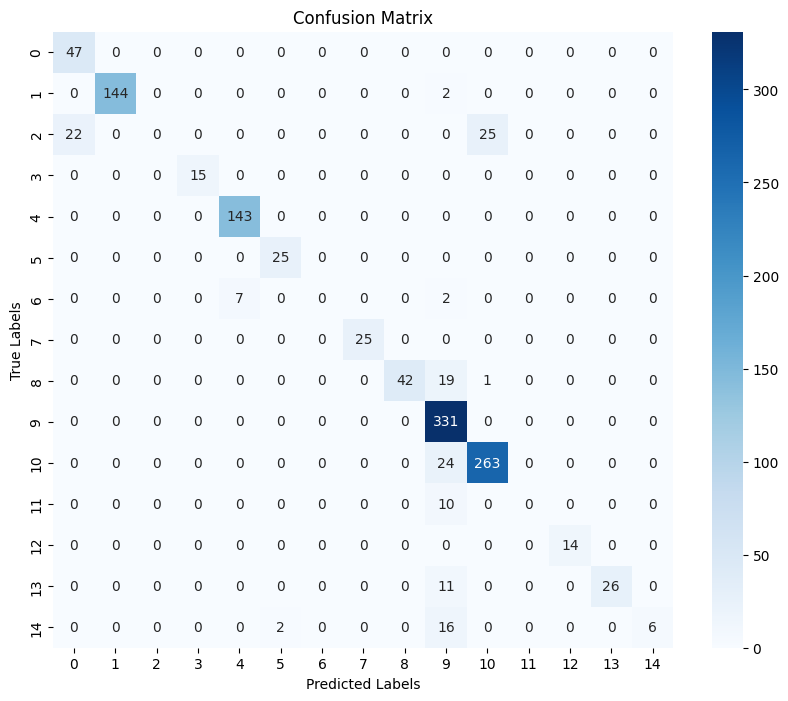

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example confusion matrix (replace with your actual confusion matrix)


# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()